# Linear Solvers Quickstart

This tutorial illustrates the basic usage and functionality of ProbNum's linear solver. 

In particular:

- Loading a random linear system from ProbNum's `problems.zoo`.
- Solving the system with one of ProbNum's linear solvers.
- Visualizing the return objects of the solver: These are distributions that describe the values of possible solutions and how probable they are.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm 

plt.style.use("../../probnum.mplstyle")

## Linear Systems & Linear Solvers

Consider a linear system of the form

$$
A \mathbf{x} = \mathbf{b}
$$
where $A\in\mathbb{R}^{n\times n}$ is a symmetric positive definite matrix, $\mathbf{b}\in\mathbb{R}^n$ is a vector and $\mathbf{x}\in\mathbb{R}^n$ is the unknown solution of the linear system. 

Solving such a linear system is arguably one of the most fundamental computations in statistics, machine learning and scientific computation. Many problems can be reduced to the solution of one or many (large-scale) linear systems. Some examples include least-squares regression, kernel methods, second-order optimization, quadratic programming, Kalman filtering, linear differential equations and all Gaussian (process) inference. Here, we will solve such a system using one of ProbNum' *probabilistic linear solvers*.


## Loading a Test Problem with ProbNums's `problems.zoo` package

We begin by creating a random linear system. ProbNum lets you quickly generate test problems via its `problem.zoo` package. In particular we generate an $n=25$ dimensional symmetric positive definite random matrix $A$ using `random_spd_matrix` with a predefined eigenspectrum, as well as a normal random vector $\mathbf{b}$.


In [2]:
import numpy as np
from probnum.problems.zoo.linalg import random_spd_matrix

rng = np.random.default_rng(42)  # for reproducibility
n = 25  # dimensionality

# generate linear system
spectrum = 10 * np.linspace(0.5, 1, n) ** 4
A = random_spd_matrix(rng=rng, dim=n, spectrum=spectrum)
b = rng.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print("Eigenvalues: {}".format(np.linalg.eigvalsh(A)))

Matrix condition: 16.00
Eigenvalues: [ 0.625       0.73585981  0.8608519   1.00112915  1.15788966  1.33237674
  1.52587891  1.73972989  1.97530864  2.23403931  2.51739125  2.82687905
  3.1640625   3.53054659  3.92798153  4.35806274  4.82253086  5.32317173
  5.86181641  6.44034115  7.06066744  7.72476196  8.43463662  9.19234853
 10.        ]


Now we visualize the linear system.

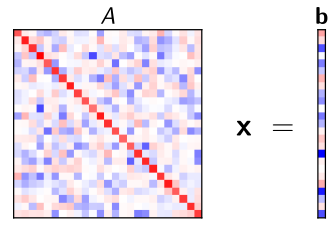

In [3]:
# Plot linear system
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(5, 3.5),
    sharey=True,
    squeeze=False,
    gridspec_kw={"width_ratios": [4, 0.25, 0.25, 0.25]},
)

vmax = np.max(np.hstack([A, b]))
vmin = np.min(np.hstack([A, b]))

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

axes[0, 0].imshow(A, cmap="bwr", vmin=vmin, vmax=vmax, norm=norm)
axes[0, 0].set_title("$A$", fontsize=24)
axes[0, 1].text(0.5, A.shape[0] / 2, "$\\bm{x}$", va="center", ha="center", fontsize=32)
axes[0, 1].axis("off")
axes[0, 2].text(0.5, A.shape[0] / 2, "$=$", va="center", ha="center", fontsize=32)
axes[0, 2].axis("off")
axes[0, 3].imshow(b, cmap="bwr", vmin=vmin, vmax=vmax, norm=norm)
axes[0, 3].set_title("$\\bm{b}$", fontsize=24)
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Solve the Linear System with ProbNum's solver

We now use ProbNum's probabilistic linear solver `problinsolve` to estimate the solution vector $\mathbf{x}$.
The algorithm iteratively chooses *actions* $\mathbf{s}$ and makes linear *observations* $\mathbf{y}=A \mathbf{s}$ to update its belief over the solution $\mathbf{x}$, the matrix $A$ and its inverse $H:=A^{-1}$. We do not run the solver to convergence here (which would require 25 iterations and yield an exact solution) but only run it for `maxiter`=10 iterations.

In [4]:
from probnum.linalg import problinsolve

# Solve with probabilistic linear solver
x, Ahat, Ainv, info = problinsolve(A=A, b=b, maxiter=10)
print(info)

{'iter': 10, 'maxiter': 10, 'resid_l2norm': 0.022193410186189838, 'trace_sol_cov': 27.593259516810043, 'conv_crit': 'maxiter', 'rel_cond': None}


## Visualization of Return Objects & Estimated Uncertainty 

The solver returns random variables $\mathsf{x}$, $\mathsf{A}$, and $\mathsf{H}:=\mathsf{A}^{-1}$ (described by distributions) which are called `x`, `Ahat` and `Ainv` respectively in the cell above. 
Those distributions describe possible values of the solution $\mathbf{x}$ of the linear system, the matrix $A$ and its inverse $H=A^{-1}$ respectively and how probable they are being considered by the solver. 
In other words, the distributions describe the uncertainty the solvers still has about the value of their respective quantity. 
Below we visualize those distributions. For all of them, the mean estimator $\mathbb{E}(\cdot)$ of the random variable can be used as a "best guess" for the true value of each quantity. In fact, the mean estimate of $\hat{x}:=\mathbb{E}(\mathsf{x})$ in this particular tutorial coincides with the conjugate gradient solution (see e.g., [1, 2]).  

### Solution $\mathsf{x}$

The solution object `x` is a normal distribution of size of the linear system (in this case $n=25$) which quantifies the uncertainty over the solution. The mean $\mathbb{E}(\mathsf{x})$ of the random variable is the "best guess" for $\mathbf{x}$. The covariance matrix (of which we only print the first row below) quantifies possible deviation of the solution from the mean. We can also sample from the normal distribution to obtain possible solution vectors $\mathsf{x}_1$, $\mathsf{x}_2$, ...

In [5]:
x

<Normal with shape=(25,), dtype=float64>

In [6]:
x.mean

array([ 0.42788816,  0.16474553, -0.96424151,  0.33005408, -0.00997482,
       -0.78171168,  0.72201347,  0.13435145,  0.22638651, -0.16099379,
        0.55113217, -0.58788207,  0.31004151,  0.03915161,  0.77811749,
        0.28117185, -1.29500489, -0.30271868,  0.12517057, -0.22116673,
        0.95021376, -1.14660937,  0.42109823,  0.09342332, -1.21668129])

In [7]:
x.cov.todense()[0, :]

array([ 1.29798046, -0.23774221,  0.07398613,  0.22233822,  0.13468161,
        0.06208167, -0.15984746, -0.14505979,  0.07847154,  0.07137013,
       -0.18547251,  0.23679621,  0.02243258,  0.00966828, -0.23528335,
       -0.08771866,  0.46921949, -0.09780891, -0.09731978, -0.12138277,
        0.06977705,  0.30437328, -0.00546743, -0.01558035,  0.06371965])

In [8]:
n_samples = 10
x_samples = x.sample(rng=rng, size=n_samples)
x_samples.shape

(10, 25)

Furthermore, the standard deviations together with the mean $\mathbb{E}(\mathsf{x})$ yield credible intervals for each dimension (entry) of $\mathbf{x}$. Credible intervals are a quick way to visualize the numerical uncertainty, but keep in mind that they only consider marginal (per element) distributions of $\mathsf{x}$ and do not capture correlations between the entries of $\mathsf{x}$.

In the plot below, the samples are drawn from the joint distribution of $\mathsf{x}$ taking into account cross correlations between the entries. The error bars only show the marginal credible intervals.

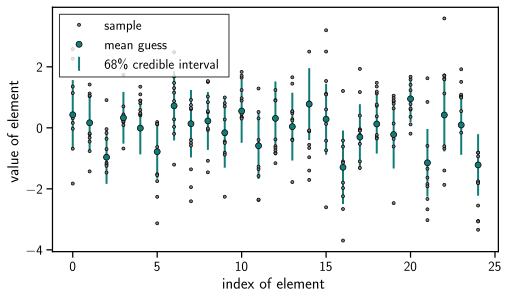

In [9]:
plt.figure()
plt.plot(x_samples[0, :], '.', color='gray', label='sample')
plt.plot(x_samples[1:, :].T, '.', color='gray') 
plt.errorbar(np.arange(0, 25), x.mean, 1 * x.std, ls='none', 
             label='68\% credible interval')
plt.plot(x.mean, 'o', color='C0', label='mean guess')
plt.xlabel("index of element")
plt.ylabel("value of element")
plt.legend()
plt.show()    

Here are the credible intervals printed out:

In [10]:
print("68% marginal credible intervals of the entries of x")
for i in range(25):
    print(f"element {i : >2}: {x.mean[i]: 0.2f}  pm  {1 * x.std[i]:.2f}")

68% marginal credible intervals of the entries of x
element  0:  0.43  pm  1.14
element  1:  0.16  pm  0.91
element  2: -0.96  pm  0.87
element  3:  0.33  pm  0.85
element  4: -0.01  pm  0.86
element  5: -0.78  pm  0.88
element  6:  0.72  pm  1.14
element  7:  0.13  pm  1.11
element  8:  0.23  pm  0.95
element  9: -0.16  pm  1.15
element 10:  0.55  pm  1.04
element 11: -0.59  pm  1.09
element 12:  0.31  pm  1.21
element 13:  0.04  pm  1.11
element 14:  0.78  pm  1.18
element 15:  0.28  pm  1.16
element 16: -1.30  pm  1.21
element 17: -0.30  pm  1.08
element 18:  0.13  pm  0.97
element 19: -0.22  pm  1.11
element 20:  0.95  pm  0.77
element 21: -1.15  pm  1.11
element 22:  0.42  pm  1.19
element 23:  0.09  pm  0.98
element 24: -1.22  pm  1.01


### System Matrix $\mathsf{A}$ and its Inverse $\mathsf{H}$

For completeness, we also illustrate the random variables $\mathsf{A}$ and $\mathsf{H}$. These quantities are not needed to describe the solution $\mathbf{x}$ and can usually be disregarded. However, in certain cases it may be of interest to acquire an approximate representation of $A$ or $H$, especially when it is infeasible to work with $A$ or $H$ directly due to their dimensionality. 

Indeed, it might sound confusing at first that the solver even constructs a belief about the matrix $A$ that initially defined the linear system, but keep in mind that linear solvers generally do not have nor require access to $A$ but only to a function handle of the matrix-vector product $\mathcal{A}(\mathbf{s}):=A\mathbf{s}$, $\mathcal{A}: \mathbb{R}^n \rightarrow \mathbb{R}^n$. The matrix might for all practical purposes be unknown (in large liner systems it is often impossible to even construct it in memory).


Both return objects `A` and `Ainv` are matrix-valued normal distributions describing the random variables $\mathsf{A}$ and $\mathsf{H}$.
We plot the mean $\mathbb{E}(\mathsf{A})$ of $\mathsf{A}$, two samples $\mathsf{A}_1$ and $\mathsf{A}_2$ as well as the ground truth $A$; analogously for $\mathsf{H}$  below. The mean $\mathbb{E}(\mathsf{A})$ can be used as estimate for $A$, same for $\mathbb{E}(\mathsf{H})$ and $H$.

In [11]:
Ahat

<Normal with shape=(25, 25), dtype=float64>

In [12]:
Ainv

<Normal with shape=(25, 25), dtype=float64>

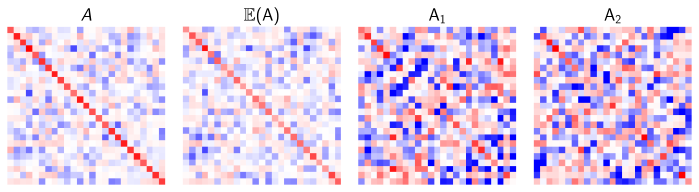

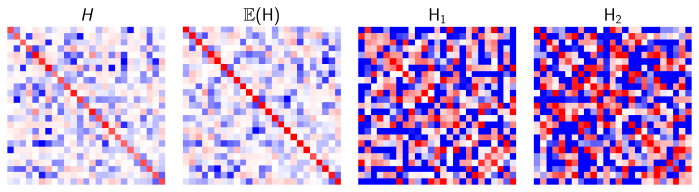

In [13]:
# Draw samples
rng = np.random.default_rng(seed=42)
Ahat_samples = Ahat.sample(rng=rng, size=3)
Ainv_samples = Ainv.sample(rng=rng, size=3)

vmax = np.max(np.hstack([A, b]))
vmin = np.min(np.hstack([A, b]))

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot A
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

H = np.linalg.inv(A)
vmax = np.max(H)
vmin = np.min(H)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot H
rvdict = {
    "$H$": H,
    "$\mathbb{E}(\mathsf{H})$": Ainv.mean.todense(),
    "$\mathsf{H}_1$": Ainv_samples[0],
    "$\mathsf{H}_2$": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

Especially the mean estimates look fairly close to the true values $A$ and $H$, even though the solver only ran for `maxiter`$=10$ steps.

We can see that the uncertainty of the solver about these quantities is still relatively high by looking at the samples from $\mathsf{A}$ and $\mathsf{H}$ .

## References

[1] J. Wenger & P. Hennig, *Probabilistic Linear Solvers for Machine Learning*, 34th Conference on Neural Information Processing Systems (NeurIPS), 2020.

[2] P. Hennig, *Probabilistic interpretation of linear solvers*, SIAM Journal on Optimization, 2015.

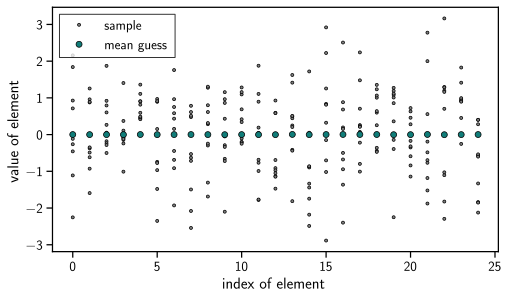

In [14]:
xnp = np.linalg.solve(A, b)[:, 0]

plt.figure()

plt.plot(x_samples[0, :] -xnp, '.', color='gray', label='sample')
plt.plot((x_samples[1:, :] - xnp).T, '.', color='gray') 
plt.plot(x.mean - xnp, 'o', color='C0', label='mean guess')
plt.xlabel("index of element")
plt.ylabel("value of element")
plt.legend()
plt.show()